In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from arch import arch_model

In [2]:
def download_data(ticker, start_date, end_date):
    """
    Download historical stock data from Yahoo Finance.

    Parameters:
    ticker (str): Stock ticker symbol.
    start_date (str): Start date in 'YYYY-MM-DD' format.
    end_date (str): End date in 'YYYY-MM-DD' format.

    Returns:
    pd.DataFrame: Historical stock data.
    """
    data = yf.download(ticker, start=start_date, end=end_date)
    data['Date'] = data.index
    data = data[['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']]
    return data

In [3]:
ticker_list=['BHARTIARTL.NS', 'HDFCBANK.NS', 'APOLLOHOSP.NS','TCS.NS','LT.NS','INFY.NS','ITC.NS','RELIANCE.NS','ICICIBANK.NS','BAJFINANCE.NS']

start_date='2018-07-27'
end_date='2021-07-27'
df = yf.download(tickers=ticker_list,
                 start=start_date,
                 end=end_date).stack()
df.columns=df.columns.str.lower()
df['signal'] = None

[*********************100%***********************]  10 of 10 completed


In [4]:
df

Price                                      adj close        close  \
Date                      Ticker                                    
2018-07-27 00:00:00+00:00 APOLLOHOSP.NS   912.826477   933.849976   
                          BAJFINANCE.NS  2663.840820  2713.699951   
                          BHARTIARTL.NS   318.020721   328.688538   
                          HDFCBANK.NS    1048.146606  1101.074951   
                          ICICIBANK.NS    280.791779   293.200012   
...                                              ...          ...   
2021-07-26 00:00:00+00:00 INFY.NS        1507.388550  1603.900024   
                          ITC.NS          189.347763   211.149994   
                          LT.NS          1519.924316  1597.599976   
                          RELIANCE.NS    1897.531860  1916.931885   
                          TCS.NS         3004.010498  3197.550049   

Price                                           high          low  \
Date                      Ticker                                    
2018-07-27 00:00:00+00:00 APOLLOHOSP.NS   945.099976   930.049988   
                          BAJFINANCE.NS  2724.500000  2667.050049   
                          BHARTIARTL.NS   336.980103   316.927124   
                          HDFCBANK.NS    1105.974976  1092.349976   
                          ICICIBANK.NS    295.149994   282.200012   
...                                              ...          ...   
2021-07-26 00:00:00+00:00 INFY.NS        1611.650024  1594.099976   
                          ITC.NS          215.350006   210.800003   
                          LT.NS          1627.300049  1592.800049   
                          RELIANCE.NS    1957.682251  1911.624634   
                          TCS.NS         3224.250000  3190.850098   

Price                                           open    volume signal  
Date                      Ticker                                       
2018-07-27 00:00:00+00:00 APOLLOHOSP.NS   945.000000    355108   None  
                          BAJFINANCE.NS  2685.000000    958703   None  
                          BHARTIARTL.NS   324.362488   9016962   None  
                          HDFCBANK.NS    1100.974976   5277298   None  
                          ICICIBANK.NS    284.899994  30926969   None  
...                                              ...       ...    ...  
2021-07-26 00:00:00+00:00 INFY.NS        1594.099976   4586710   None  
                          ITC.NS          214.000000  47263771   None  
                          LT.NS          1611.750000   2219416   None  
                          RELIANCE.NS    1945.683350   6194834   None  
                          TCS.NS         3200.000000   1259611   None  

[7360 rows x 7 columns]

In [5]:
def predict_volatility(data):
    garch_model = arch_model(data, p=2, q=1, vol='Garch')
    model_fit = garch_model.fit(disp='off')
    forecast = model_fit.forecast(horizon=1)
    prediction = forecast.variance.iloc[-1, 0]
    return prediction

In [6]:
def generate_signal(df):



    df['Log_Returns'] = np.log(df['adj close']).diff() * 100
    df['true_vol'] = df['Log_Returns'].rolling(15).var()

    df['predictions'] = df['Log_Returns'].rolling(15).apply(lambda x: predict_volatility(x))

    df['roll_mean'] = df['adj close'].rolling(15).mean()
    df['bb_up'] = df['roll_mean'] + 2 * df['adj close'].rolling(15).std()
    df['bb_down'] = df['roll_mean'] - 2 * df['adj close'].rolling(15).std()

    
    df['signal'] = np.nan

    
    for i in range(1, len(df)):
        if (df['adj close'].iloc[i] > df['bb_up'].iloc[i]) and (df['adj close'].iloc[i - 1] <= df['bb_up'].iloc[i - 1]):
            
            if df['predictions'].iloc[i] <= df['true_vol'].iloc[i]:
                df['signal'].iloc[i] = 1  
            else:
                df['signal'].iloc[i] = -1  
        elif (df['adj close'].iloc[i] < df['bb_down'].iloc[i]) and (df['adj close'].iloc[i - 1] >= df['bb_down'].iloc[i - 1]):
 
            if df['predictions'].iloc[i] <= df['true_vol'].iloc[i]:
                df['signal'].iloc[i] = -1 
            else:
                df['signal'].iloc[i] = 1  

    return df  


grouped_df = df.groupby('Ticker')
df = grouped_df.apply(generate_signal)

c:\Users\agraw\anaconda3\Lib\site-packages\arch\univariate\base.py:311: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.09184. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 10 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [7]:
def backtest(df, initial_capital):
    
    positions = pd.DataFrame(index=df.index)
    positions['Stock'] = 0.0  
    unique_dates = df.index.get_level_values('Date').unique()
    
    
    portfolio = pd.DataFrame(index=unique_dates, columns=['cash', 'holdings', 'total', 'returns'])
    portfolio['cash'] = initial_capital
    portfolio['holdings'] = 0.0
    portfolio['total'] = initial_capital
    portfolio['returns'] = 0.0

    previous_date = None
    for date in unique_dates:
        data = df.loc[date]
        
        total_cash = portfolio.loc[previous_date, 'cash'] if previous_date is not None else initial_capital
        
        for ticker in data.index.get_level_values('Ticker').unique():
            stock_data = data.loc[ticker]
            
            if (date, ticker) not in positions.index:
                positions.loc[(date, ticker), 'Stock'] = 0.0
            
            previous_stock = positions.loc[(previous_date, ticker), 'Stock'] if previous_date is not None else 0
            
       
            if stock_data['signal'] == 1 and total_cash >= stock_data['close'] * 100:
                positions.loc[(date, ticker), 'Stock'] = previous_stock + 100
                total_cash -= stock_data['adj close'] * 100
            
            
            elif stock_data['signal'] == -1 and previous_stock >= 100:
                positions.loc[(date, ticker), 'Stock'] = previous_stock - 100
                total_cash += stock_data['adj close'] * 100
            
           
            else:
                positions.loc[(date, ticker), 'Stock'] = previous_stock
            
            
            portfolio.loc[date, 'holdings'] += positions.loc[(date, ticker), 'Stock'] * stock_data['close']
        
        
        portfolio.loc[date, 'cash'] = total_cash
        portfolio.loc[date, 'total'] = portfolio.loc[date, 'cash'] + portfolio.loc[date, 'holdings']
        
        
        if previous_date is not None:
            portfolio.loc[date, 'returns'] = (portfolio.loc[date, 'total'] / portfolio.loc[previous_date, 'total']) - 1

       
        previous_date = date

    return portfolio


In [8]:
df_reset = df.reset_index(level=0, drop=True)
df_reset=df_reset.sort_index()
df_reset

Price                                      adj close        close  \
Date                      Ticker                                    
2018-07-27 00:00:00+00:00 APOLLOHOSP.NS   912.826477   933.849976   
                          BAJFINANCE.NS  2663.840820  2713.699951   
                          BHARTIARTL.NS   318.020721   328.688538   
                          HDFCBANK.NS    1048.146606  1101.074951   
                          ICICIBANK.NS    280.791779   293.200012   
...                                              ...          ...   
2021-07-26 00:00:00+00:00 INFY.NS        1507.388550  1603.900024   
                          ITC.NS          189.347763   211.149994   
                          LT.NS          1519.924316  1597.599976   
                          RELIANCE.NS    1897.531860  1916.931885   
                          TCS.NS         3004.010498  3197.550049   

Price                                           high          low  \
Date                      Ticker                                    
2018-07-27 00:00:00+00:00 APOLLOHOSP.NS   945.099976   930.049988   
                          BAJFINANCE.NS  2724.500000  2667.050049   
                          BHARTIARTL.NS   336.980103   316.927124   
                          HDFCBANK.NS    1105.974976  1092.349976   
                          ICICIBANK.NS    295.149994   282.200012   
...                                              ...          ...   
2021-07-26 00:00:00+00:00 INFY.NS        1611.650024  1594.099976   
                          ITC.NS          215.350006   210.800003   
                          LT.NS          1627.300049  1592.800049   
                          RELIANCE.NS    1957.682251  1911.624634   
                          TCS.NS         3224.250000  3190.850098   

Price                                           open    volume  signal  \
Date                      Ticker                                         
2018-07-27 00:00:00+00:00 APOLLOHOSP.NS   945.000000    355108     NaN   
                          BAJFINANCE.NS  2685.000000    958703     NaN   
                          BHARTIARTL.NS   324.362488   9016962     NaN   
                          HDFCBANK.NS    1100.974976   5277298     NaN   
                          ICICIBANK.NS    284.899994  30926969     NaN   
...                                              ...       ...     ...   
2021-07-26 00:00:00+00:00 INFY.NS        1594.099976   4586710     NaN   
                          ITC.NS          214.000000  47263771     NaN   
                          LT.NS          1611.750000   2219416     NaN   
                          RELIANCE.NS    1945.683350   6194834     NaN   
                          TCS.NS         3200.000000   1259611     NaN   

Price                                    Log_Returns  true_vol  predictions  \
Date                      Ticker                                              
2018-07-27 00:00:00+00:00 APOLLOHOSP.NS          NaN       NaN          NaN   
                          BAJFINANCE.NS          NaN       NaN          NaN   
                          BHARTIARTL.NS          NaN       NaN          NaN   
                          HDFCBANK.NS            NaN       NaN          NaN   
                          ICICIBANK.NS           NaN       NaN          NaN   
...                                              ...       ...          ...   
2021-07-26 00:00:00+00:00 INFY.NS           0.842114  1.254453     0.757592   
                          ITC.NS           -0.590256  0.789503     1.020339   
                          LT.NS            -0.881797  2.762772     3.669356   
                          RELIANCE.NS      -1.379567  0.869185     0.876387   
                          TCS.NS           -0.477353  0.503609     0.205614   

Price                                      roll_mean        bb_up      bb_down  
Date                      Ticker                                                
2018-07-27 00:00:00+00:00 APOLLOHOSP.NS          Na

In [9]:

import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

def generate_report(portfolio, initial_capital):
    # Total return calculation
    total_return = portfolio['total'].iloc[-1] / initial_capital - 1

    # Annualized return calculation
    annualized_return = (1 + total_return) ** (252 / len(portfolio)) - 1 

    # Annualized volatility calculation
    annualized_volatility = portfolio['returns'].std() * np.sqrt(252) 

    # Sharpe ratio calculation
    sharpe_ratio = annualized_return / annualized_volatility

    # Drawdown calculation
    portfolio['rolling_max'] = portfolio['total'].cummax()  # Track the rolling maximum
    portfolio['drawdown'] = (portfolio['total'] - portfolio['rolling_max']) / portfolio['rolling_max']  # Drawdown formula
    max_drawdown = portfolio['drawdown'].min()  # The largest drawdown (most negative value)

    # Print performance metrics
    print(f'Total Return: {total_return:.2%}')
    print(f'Annualized Return: {annualized_return:.2%}')
    print(f'Annualized Volatility: {annualized_volatility:.2%}')
    print(f'Sharpe Ratio: {sharpe_ratio:.2f}')
    print(f'Max Drawdown: {max_drawdown:.2%}')

    # Download NIFTY data
    nifty = yf.download(tickers='^NSEI', start='2018-07-27', end='2021-07-27')
    first = nifty['Close'].iloc[0]
    nifty['Close'] = nifty['Close'] * initial_capital / first

    # Plot equity curve
    plt.figure(figsize=(12, 8))
    plt.plot(nifty['Close'], label='NIFTY 50', color='red')
    plt.plot(portfolio['total'], label='Total Portfolio Value', color='blue')
    plt.title('Equity Curve')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.axhline(y=initial_capital, color='red', linestyle='--', label='Initial Capital')
    plt.legend()
    plt.grid()
    plt.show()

# Sample usage (Make sure you have the correct 'portfolio' DataFrame with 'total' and 'returns' columns)
# generate_report(portfolio, initial_capital)



In [10]:
portfolio=backtest(df_reset,1000000)

C:\Users\agraw\AppData\Local\Temp\ipykernel_7368\628151342.py:46: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '888635.0341796875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[date, 'cash'] = total_cash
C:\Users\agraw\AppData\Local\Temp\ipykernel_7368\628151342.py:47: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1002670.60546875' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  portfolio.loc[date, 'total'] = portfolio.loc[date, 'cash'] + portfolio.loc[date, 'holdings']


Total Return: 112.77%
Annualized Return: 29.50%
Annualized Volatility: 23.27%
Sharpe Ratio: 1.27
Max Drawdown: -39.47%


[*********************100%***********************]  1 of 1 completed


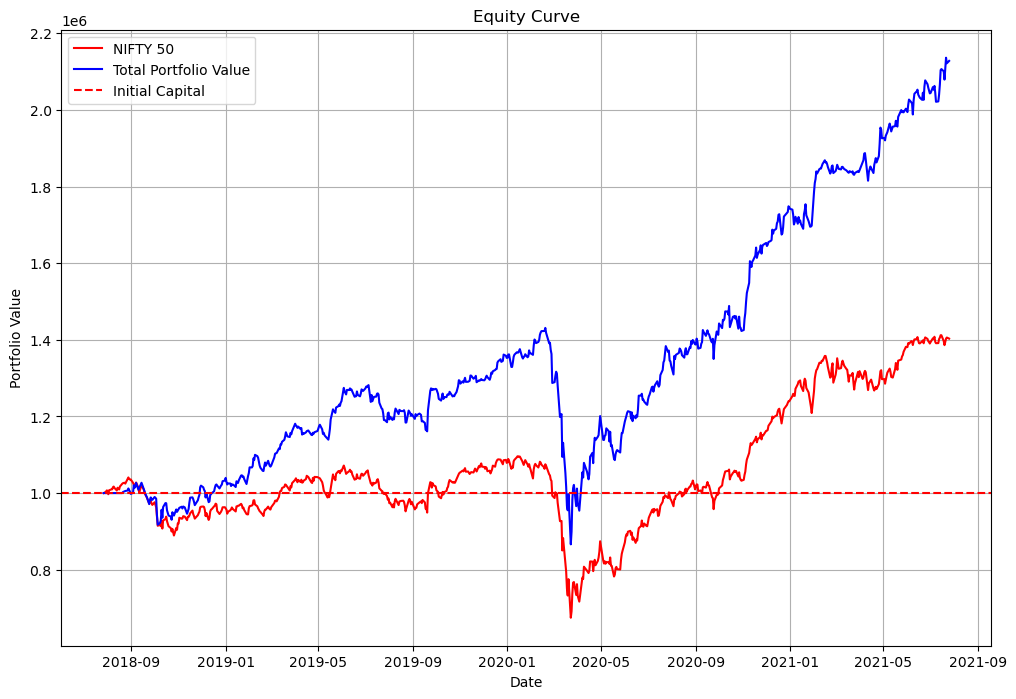

In [11]:
generate_report(portfolio,1000000)